In [2]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST
#import torchvision.transforms as transforms
from torch.utils.data import Dataset
import spacy
#import pytorch_lightning as pl
#from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import scipy
from sklearn.manifold import TSNE
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC, SVR
from sklearn.multioutput import MultiOutputRegressor
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import scipy.io
import random
import inlp
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from typing import Tuple, Dict
from typing import List
import tqdm
import mnist_reader
import urllib
import time
import pickle
%load_ext autoreload
%autoreload

In [36]:
def load_wiki(url = "http://nlp.biu.ac.il/~ravfogs/resources/wiki.1million.raw.txt"):
    
  response = urllib.request.urlopen(url)
  raw = response.read().decode('utf8')
  sents = raw.split("\n")
  
  return sents[:]


def create_docs(sentences: List[str]) -> List[spacy.tokens.Doc]:

    #parsing and toekenizing (NOTE: takes about 10 minutes)
    
    nlp = spacy.load('en_core_web_sm')
    nlp.remove_pipe("ner")
    
    start = time.time()
    
    docs = list(nlp.pipe(sentences, batch_size = 100))
    
    docs = list(docs)
    print(time.time() - start)
    
    return docs


def create_dataset_for_related_words(docs, num_samples = 100*1e3, all_descendents = True):
    
    data = []
    pbar = tqdm.tqdm(total = num_samples)
    
    while len(data) < num_samples:
        
        doc = random.choice(docs)
        sent = " ".join([tok.text for tok in doc])
        if len(doc) < 9: continue
        
        for i,tok in enumerate(doc):
            print(i)
            pbar.update(2)
            head = tok.head
            children = list(tok.children)
            if all_descendents:
                children = list(tok.subtree)
            related = children #[head] + children
            if len(related) == 0: continue
                
            random_related = random.choice(related)
            data.append((sent, doc, i, random_related.i, 1))
            
            # choose negative example
            
            chosen = False
            ind = 0
            while not chosen:
                
                random_word = random.choice(doc)
                ind += 1
                if ind > 60: break
                    
                if random_word not in related:
                    chosen = True
                    data.append((sent, doc, i, random_word.i, 0))
    
    random.shuffle(data)
    return data
                
    
def create_dataset_for_depth(docs, num_samples = 25*1e3):
    
    data = []
    pbar = tqdm.tqdm(total = num_samples)
    i = 0
    
    while len(data) < num_samples:
        pbar.update(1)
        i += 1
        doc = random.choice(docs)
        sent = " ".join([tok.text for tok in doc])
        if len(doc) < 9: continue
        
        for i,tok in enumerate(doc):
            depth = 0
            head = tok
            while head.dep_ != "ROOT":
                
                depth += 1
                head = head.head
                
            data.append((sent, doc, i, depth))
    
    random.shuffle(data)
    return data        

## Collect data

In [37]:
#sents = load_wiki()
with open("sents.50k.pickle", "rb") as f:
    
    sents = pickle.load(f)

In [38]:
sents = sents[:50000]
docs = create_docs(sents)

0.913182258605957


In [39]:
data = create_dataset_for_related_words(docs, num_samples = 60 * 1e3, all_descendents = True)
print(len(data))


  0%|          | 0/60000.0 [00:00<?, ?it/s]
  6%|▌         | 3630/60000.0 [00:00<00:01, 28825.58it/s]

0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
1


 11%|█         | 6616/60000.0 [00:00<00:01, 27298.11it/s]
 16%|█▌        | 9604/60000.0 [00:00<00:01, 26748.52it/s]


9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
1


 21%|██        | 12592/60000.0 [00:00<00:01, 26459.06it/s]
 26%|██▌       | 15580/60000.0 [00:00<00:01, 26012.11it/s]

12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
0
1
2
3
4
5
6
7


 31%|███       | 18566/60000.0 [00:00<00:01, 26383.63it/s]
 36%|███▌      | 21554/60000.0 [00:00<00:01, 27009.96it/s]


1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
0
1
2
3
4
5
6
7
8
9
10
11


 41%|████      | 24542/60000.0 [00:00<00:01, 27619.84it/s]
 46%|████▌     | 27530/60000.0 [00:01<00:01, 28208.23it/s]


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


 51%|█████     | 30516/60000.0 [00:01<00:01, 28663.50it/s]
 56%|█████▌    | 33504/60000.0 [00:01<00:00, 28417.47it/s]

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9



 61%|██████    | 36492/60000.0 [00:01<00:00, 28536.58it/s]
 66%|██████▌   | 39480/60000.0 [00:01<00:00, 28737.52it/s]

12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6


 71%|███████   | 42466/60000.0 [00:01<00:00, 28915.17it/s]
 76%|███████▌  | 45454/60000.0 [00:01<00:00, 28965.47it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
0
1
2
3
4
5
6
7



 81%|████████  | 48340/60000.0 [00:01<00:00, 22977.36it/s]

10
11
12
13
14
15
16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



 85%|████████▌ | 51256/60000.0 [00:01<00:00, 24538.12it/s]
 90%|█████████ | 54174/60000.0 [00:02<00:00, 25766.79it/s]


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


 95%|█████████▌| 57126/60000.0 [00:02<00:00, 26788.47it/s]
61384it [00:02, 26482.60it/s]                             

17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1

In [7]:
data[0]

("a turn - of - the-20th - century apartment construction boom allowed the expansion of chicago 's african american ghetto southward , and the original inhabitants mostly left the area .",
 a turn-of-the-20th-century apartment construction boom allowed the expansion of chicago 's african american ghetto southward, and the original inhabitants mostly left the area.,
 4,
 4,
 1)

In [73]:
with open("sents.50k.pickle", "wb") as f:
    pickle.dump(sents, f)
    
with open("docs.50k.pickle", "wb") as f:
    pickle.dump(docs, f)

## Encoder

In [40]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu'):

        config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str]) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layer = 4):
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            return (predictions.squeeze(), orig2tok)
        

def collect_bert_states_for_grammatical_relation(bert, data: List[Tuple]):
    
    
    for i,d in tqdm.tqdm(enumerate(data), total = len(data)):
        
        sent = d[0]
        doc = d[1]
        j,k = d[2], d[3]
        label = d[4]
        
        preds, orig2tok = bert.encode(sent)

        x1,x2 = preds[orig2tok[j]], preds[orig2tok[k]]
        data[i] = (sent, doc, j, k, x1, x2, label)
    
    return data


def collect_bert_states_for_depth(bert, data: List[Tuple]):
    
    
    for i,d in tqdm.tqdm(enumerate(data), total = len(data)):
        
        sent = d[0]
        doc = d[1]
        jj = d[2]
        label = d[3]
        
        preds, orig2tok = bert.encode(sent)
        v = preds[orig2tok[jj]]
        data[i] = (sent, doc, jj, v, label)
    
    return data
        

In [41]:
bert = BertEncoder(device = "cuda")

In [43]:
#data_with_states = collect_bert_states_for_depth(bert, data[:])
data_with_states = collect_bert_states_for_grammatical_relation(bert, data)


  2%|▏         | 1293/60039 [00:16<12:16, 79.81it/s]


  4%|▍         | 2599/60039 [00:31<11:35, 82.59it/s]


  7%|▋         | 3913/60039 [00:47<11:46, 79.43it/s]


  9%|▊         | 5211/60039 [01:03<10:58, 83.29it/s]


 11%|█         | 6512/60039 [01:19<10:44, 83.12it/s]


 13%|█▎        | 7824/60039 [01:35<10:14, 85.01it/s]


 15%|█▌        | 9138/60039 [01:50<10:02, 84.49it/s]


 17%|█▋        | 10443/60039 [02:06<09:49, 84.08it/s]


 20%|█▉        | 11730/60039 [02:21<09:42, 82.92it/s]


 22%|██▏       | 13017/60039 [02:36<09:13, 84.91it/s]


 24%|██▍       | 14304/60039 [02:51<08:59, 84.74it/s]


 26%|██▌       | 15591/60039 [03:06<08:43, 84.87it/s]


 28%|██▊       | 16878/60039 [03:21<08:28, 84.91it/s]


 30%|███       | 18165/60039 [03:37<08:16, 84.29it/s]


 32%|███▏      | 19452/60039 [03:52<07:57, 84.97it/s]


 35%|███▍      | 20739/60039 [04:07<07:44, 84.60it/s]


 37%|███▋      | 22026/60039 [04:22<07:27, 85.01it/s]


 39%|███▉      | 23313/60039 [04:37<07:09, 85.55it/s]


 41%|████      | 24600/60039 [04:53<06:59, 84.46it/s]


 43%|████▎     | 25887/60039 [05:08<06:42, 84.93it/s]


 45%|████▌     | 27174/60039 [05:23<06:24, 85.40it/s]


 47%|████▋     | 28461/60039 [05:38<06:13, 84.46it/s]


 50%|████▉     | 29748/60039 [05:53<05:55, 85.29it/s]


 52%|█████▏    | 31035/60039 [06:08<05:40, 85.20it/s]


 54%|█████▍    | 32322/60039 [06:23<05:27, 84.74it/s]


 56%|█████▌    | 33609/60039 [06:38<05:12, 84.46it/s]


 58%|█████▊    | 34896/60039 [06:54<04:59, 84.03it/s]


 60%|██████    | 36183/60039 [07:09<04:40, 84.91it/s]


 62%|██████▏   | 37470/60039 [07:24<04:29, 83.72it/s]


 65%|██████▍   | 38757/60039 [07:39<04:09, 85.27it/s]


 67%|██████▋   | 40044/60039 [07:55<03:58, 83.91it/s]


 69%|██████▉   | 41331/60039 [08:10<03:39, 85.12it/s]


 71%|███████   | 42618/60039 [08:25<03:24, 85.12it/s]


 73%|███████▎  | 43905/60039 [08:40<03:09, 84.93it/s]


 75%|███████▌  | 45192/60039 [08:55<02:55, 84.54it/s]


 77%|███████▋  | 46479/60039 [09:11<02:40, 84.43it/s]


 80%|███████▉  | 47766/60039 [09:26<02:21, 86.81it/s]


 82%|████████▏ | 49053/60039 [09:41<02:09, 84.85it/s]


 84%|████████▍ | 50340/60039 [09:56<01:54, 84.47it/s]


 86%|████████▌ | 51627/60039 [10:11<01:39, 84.23it/s]


 88%|████████▊ | 52914/60039 [10:26<01:23, 85.34it/s]


 90%|█████████ | 54201/60039 [10:42<01:09, 83.56it/s]


 92%|█████████▏| 55488/60039 [10:57<00:53, 85.03it/s]


 95%|█████████▍| 56775/60039 [11:12<00:38, 85.29it/s]


 97%|█████████▋| 58062/60039 [11:27<00:23, 83.59it/s]


 99%|█████████▉| 59349/60039 [11:42<00:08, 84.74it/s]


100%|██████████| 60039/60039 [11:51<00:00, 84.44it/s]


In [19]:
data_with_states[-1]

('myton bridge 1981 an asymmetric cable stayed box girder steel swing bridge on the a63 garrison road , with spans of .',
 myton bridge 1981 an asymmetric cable stayed box girder steel swing bridge on the a63 garrison road, with spans of.,
 18,
 20,
 array([-1.87456444e-01,  1.08461356e+00,  9.40399468e-01,  6.03045642e-01,
         2.20084246e-02, -7.74817407e-01, -7.20353305e-01, -6.70134127e-01,
         5.21630287e-01, -9.04872596e-01,  5.92511356e-01, -5.65806329e-01,
        -7.66655862e-01,  1.01893432e-02, -7.80446827e-02,  3.43414233e-03,
         9.87994552e-01, -2.49244735e-01, -1.24237299e+00,  1.42883703e-01,
        -5.63627839e-01, -1.09071791e+00, -1.26149976e+00, -1.14433789e+00,
         9.98690665e-01,  2.38134384e-01, -1.13722347e-01,  5.24375498e-01,
        -3.92850161e-01,  1.21715069e-01,  4.83550370e-01,  1.50935203e-01,
         1.53615415e+00, -1.55764714e-01, -8.05191994e-02,  4.61667776e-01,
        -6.39789343e-01,  1.17900766e-01,  1.76969171e-01,  3.0273

In [44]:
with open("data_with_states.pickle", "wb") as f:
    pickle.dump(data_with_states, f)

In [45]:
random.shuffle(data_with_states)
l = int(len(data_with_states) * 0.8)
train, dev = data_with_states[:l], data_with_states[l:]
#train_x, train_y = np.array([x[-2] for x in train]), np.array([x[-1] for x in train])
train_x, train_y = np.array([np.concatenate([x[-3],x[-2]]) for x in train]), np.array([x[-1] for x in train])

max_y = max([x[-1] for x in train])
#dev_x, dev_y = np.array([x[-2] for x in dev]), np.array([x[-1] for x in dev])
dev_x, dev_y = np.array([np.concatenate([x[-3],x[-2]]) for x in dev]), np.array([x[-1] for x in dev])

normalize = False
if normalize:
    
    mean_train = np.mean(train_y, axis = 0, keepdims = True)
    mean_dev = np.mean(dev_y, axis = 0, keepdims = True)
    std_train = np.std(train_y, axis = 0)
    std_dev = np.std(dev_y, axis =0)
    
    train_y = (train_y - mean_train)/std_train
    dev_y = (dev_y - mean_dev)/std_dev

In [ ]:
model = Ridge(fit_intercept = True)
model.fit(train_x, train_y)

In [ ]:
print(model.score(dev_x, dev_y))
print(model.coef_)

In [46]:
with open("data_with_states.pickle", "rb") as f:
    data_with_states = pickle.load(f)
    data_with_states = data_with_states[:70000]

In [ ]:
clf = Ridge
params = {"fit_intercept": True}

autoregressive = True
dropout = 0.03
n = 50
P, rowspace_projections, Ws = inlp.run_inlp(clf, params, n, 768, autoregressive, min_accuracy = -1.0, X_train=train_x,
                                            Y_train=train_y, X_dev=dev_x, Y_dev=dev_y, dropout_rate = dropout)

In [ ]:
Ws[4].dot(Ws[7].T)

In [82]:
def tsne(vecs, labels, title="", words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))
  plt.figure(figsize=(6, 5))
  colors = "red", "green", "blue", "cyan", "yellow", "orange", "brown", "black", "purple", "pink"
  #colors = [(255,13,12) for n in names]
    
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
    #print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.3)
  plt.legend()
  plt.title(title)

In [ ]:
n = 3000
data_for_tsne = dev_x[:n]
data_for_tsne_docs = [tup[1] for tup in dev[:n]]
data_for_tsne_idx = [tup[2] for tup in dev[:n]]
data_for_tsen_deps = []
to_keep = ["nsubj", "dobj", "pobj", "auxpass", "amod", "ROOT"]
to_keep = ["NOUN", "VERB", "ADJ"]
vecs = []

for doc,i,v in zip(data_for_tsne_docs,data_for_tsne_idx,data_for_tsne):
    
    dep = doc[i].pos_
    if dep in to_keep:
        data_for_tsen_deps.append(doc[i].pos_)
        vecs.append(v)

vecs = np.array(vecs)
vecs_rowspace = np.zeros_like(vecs)
for p_rowspace in rowspace_projections[:]:
    
    vecs_rowspace += p_rowspace.dot(vecs.T).T

data_for_tsen_deps = np.array(data_for_tsen_deps)
print(len(vecs))
assert len(data_for_tsen_deps) == len(vecs)
tsne(vecs_rowspace, data_for_tsen_deps)

In [ ]:
tsne(vecs, data_for_tsen_deps)

In [133]:
import pickle
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import scipy
from scipy import linalg


class Dataset(torch.utils.data.Dataset):
    
    """Simple torch dataset class"""
    def __init__(self, data, device):

        self.data = data
        self.device = device

    def __len__(self):

        return len(self.data)

    def __getitem__(self, index):

        with torch.no_grad():
            
            
            v1, v2, y = self.data[index][-2], self.data[index][-3], self.data[index][-1]
            
            vec1, vec2 = torch.from_numpy(v1).float(), torch.from_numpy(v2).float()
            vec1 = vec1.to(self.device)
            vec2 = vec2.to(self.device)
            
            return vec1, vec2, torch.tensor(y).float().to(self.device)
            
            
            
class Siamese(pl.LightningModule):

    def __init__(self, X_train, X_dev, dim, batch_size, dropout_rate, device = "cuda"):
        super(Siamese, self).__init__()
        self.l1 = torch.nn.Linear(dim, 16, bias = False)
        self.l2 = torch.nn.Linear(dim, 16, bias = False)
        
        self.w1,self.w2, self.w3, self.b = torch.nn.Parameter(torch.rand(1)),torch.nn.Parameter(torch.rand(1)), torch.nn.Parameter(torch.rand(1)), torch.nn.Parameter(torch.zeros(1))
        
        self.train_data = Dataset(X_train, device)
        self.dev_data = Dataset(X_dev, device)
        self.train_gen = torch.utils.data.DataLoader(self.train_data, batch_size = batch_size, drop_last = False, shuffle=True)
        self.dev_gen = torch.utils.data.DataLoader(self.dev_data, batch_size = batch_size, drop_last = False, shuffle=True)
        self.dropout = torch.nn.Dropout(p = dropout_rate)
        self.acc = None
        self.optimizer = torch.optim.Adam(self.parameters(), weight_decay = 1e-6)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        
        self.net = torch.nn.Sequential(torch.nn.Linear(dim,128), torch.nn.ReLU(), torch.nn.Linear(128, 16))
        
    def forward(self, x1, x2):

          h1 = self.w1 * self.l1(x1)
          h2 = self.w2 * self.l1(x2)
        
          #h1, h2 = self.net(x1), self.net(x2)
             
          return h1, h2
 
    def train_network(self, num_epochs):
    
      trainer = Trainer(max_nb_epochs = num_epochs, min_nb_epochs = num_epochs, show_progress_bar = False)
      trainer.fit(self)

      return self.acc   
      
    def get_weights(self):
    
        return self.l.weight.data.detach().cpu().numpy()
    
    def get_final_representaton_for_sigmoid(self, h1, h2):
        
        dot_prod = torch.sum(h1*h2, axis = 1)
        #dot_prod = torch.sum((h1-h2)**2, axis = 1)
        #dot_prod = torch.sum(h1 - h2, axis = 1)
        dot_prod = self.w3 * dot_prod + self.b
        return dot_prod
    
    def training_step(self, batch, batch_nb):
        # REQUIRED
        x1, x2, y = batch
        h1, h2 = self.forward(self.dropout(x1), self.dropout(x2))
        dot_prod = self.get_final_representaton_for_sigmoid(h1, h2)

        loss_val =  self.loss_fn(dot_prod, y)
        correct = ((dot_prod > 0).int() == y.int()).int()
        acc = torch.sum(correct).float() /len(y)

        return {'loss': loss_val, 'val_acc': acc}
        

    def validation_step(self, batch, batch_nb):
    
        # OPTIONAL
        x1, x2, y = batch
        h1, h2 = self.forward(x1, x2)
        dot_prod = self.get_final_representaton_for_sigmoid(h1, h2)

        loss_val =  self.loss_fn(dot_prod, y)
        correct = ((dot_prod > 0).int() == y.int()).int()
        acc = torch.sum(correct).float()/len(y)
        
        return {'val_loss': loss_val, 'val_acc': acc}

    def validation_end(self, outputs):
        # OPTIONAL    
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        print("Loss is {}".format(avg_loss))
        print("Accuracy is {}".format(avg_acc))
        return {'avg_val_loss': avg_loss}

    def configure_optimizers(self):
        # REQUIRED
        #return torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        return torch.optim.Adam(self.parameters(), weight_decay = 1e-3)

    @pl.data_loader
    def train_dataloader(self):
        return self.train_gen

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        # can also return a list of val dataloaders
        return self.dev_gen

In [134]:
train_dataset, dev_dataset = Dataset(train, device = "cuda"), Dataset(dev, device = "cuda")

In [135]:
siamese = Siamese(train, dev, 768, 1024, 0.0, device = "cuda").cuda()

In [ ]:
siamese.train_network(50)

INFO:root:      Name               Type Params
0       l1             Linear   12 K
1       l2             Linear   12 K
2  dropout            Dropout    0  
3  loss_fn  BCEWithLogitsLoss    0  
4      net         Sequential  100 K
5    net.0             Linear   98 K
6    net.1               ReLU    0  
7    net.2             Linear    2 K


In [131]:
w = siamese.w1.detach().cpu().numpy() * siamese.l1.weight.detach().cpu().numpy()
#w = siamese.w1.siamese.l2.weight.detach().cpu().numpy() 
P_Rw = inlp.get_rowspace_projection(w)

## tsne

907


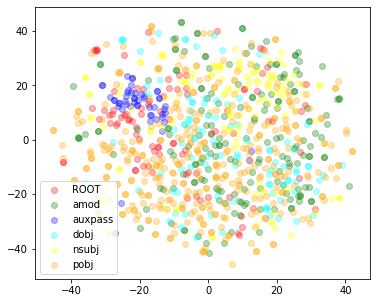

In [132]:
n = 3000
data_for_tsne = [tup[4] for tup in dev[:n]]
data_for_tsne_docs = [tup[1] for tup in dev[:n]]
data_for_tsne_idx = [tup[2] for tup in dev[:n]]
data_for_tsen_deps = []
to_keep = ["nsubj", "dobj", "pobj", "auxpass", "amod", "ROOT"]
#to_keep = ["NOUN", "VERB", "ADJ"]
vecs = []

for doc,i,v in zip(data_for_tsne_docs,data_for_tsne_idx,data_for_tsne):
    
    dep = doc[i].dep_
    if dep in to_keep:
        data_for_tsen_deps.append(doc[i].dep_)
        vecs.append(v)

vecs = np.array(vecs)
vecs_rowspace = P_Rw.dot(vecs.T).T

data_for_tsen_deps = np.array(data_for_tsen_deps)
print(len(vecs))
assert len(data_for_tsen_deps) == len(vecs)
tsne(vecs_rowspace, data_for_tsen_deps)

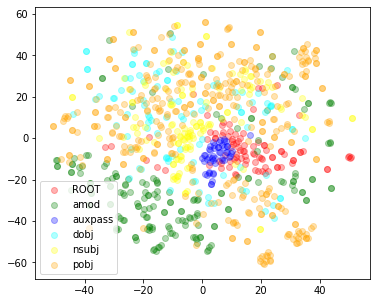

In [93]:
tsne(vecs, data_for_tsen_deps)

In [56]:
sum(train_y)/len(train_y)

0.5116903666382128